# EDA

In [ ]:
import duckdb
import pandas as pd
from pathlib import Path

# I use a path handling to show where the data and sql files are located
duckdb_path = "../data/sakila.duckdb"
sql_load_path = "../sql/load_sakila.sql"

# Removes existing datafile (starts fresh each time)
Path(duckdb_path).unlink(missing_ok=True)


with duckdb.connect(duckdb_path) as conn, open(sql_load_path, "r") as ingest_script:
    # Runs the sql script to load the sakila data into duckdb
    conn.execute(ingest_script.read())

    # loads each table into a pandas dataframe
    print("Loading tables:")
    film = conn.sql("SELECT * FROM film").df()
    actor = conn.sql("SELECT * FROM actor").df()
    film_actor = conn.sql("SELECT * FROM film_actor").df()
    category = conn.sql("SELECT * FROM category").df()
    film_category = conn.sql("SELECT * FROM film_category").df() 
    inventory = conn.sql("SELECT * FROM inventory").df()
    rental = conn.sql("SELECT * FROM rental").df()
    store = conn.sql("SELECT * FROM store").df()
    city = conn.sql("SELECT * FROM city").df()
    address = conn.sql("SELECT * FROM address").df()
    customer = conn.sql("SELECT * FROM customer").df()
    staff = conn.sql("SELECT * FROM staff").df()
    payment = conn.sql("SELECT * FROM payment").df()   
    
    # test prints to verify data loaded correctly
print(f"1st Actor: {actor.iloc[0]['first_name']} {actor.iloc[0]['last_name']}")
print(f"2nd Actor: {actor.iloc[1]['first_name']} {actor.iloc[1]['last_name']}")
print("DATA LOAD SUCCESSFUL")

# Tasks

In [ ]:
# 1a

print("MOVIES LONGER THEN 180 MINUTES/3 HOURS")
print("10 MOVIES listed from my query that is longer 180 minutes/3 hours")
print("List descending by Length:")

movie_180min_plus = duckdb.sql("""
    SELECT title, length
    FROM film
    WHERE length > 180
    ORDER BY length DESC
    LIMIT 20
""").df()
movie_180min_plus.index = movie_180min_plus.index + 1 
display(movie_180min_plus)

In [ ]:
# 1b 
# I did similar to 1a but now searching for the word love in the title instead
print("Here is the movies that have the word love in the title:")
movie_title_love = duckdb.sql("""
    SELECT title, rating, length, description
    FROM film 
    WHERE title LIKE '%LOVE%'
    """).df()
movie_title_love.index = movie_title_love.index + 1
display(movie_title_love)


In [ ]:
# 1c

print("Calculation of the length: Longest, shortest, median and average movie length:")
# My calculation for the printed statistics above

movie_length_calc = duckdb.sql("""
    SELECT
        MAX(length) as L_movie_stats,
        MIN(length) as S_movie_stats,
        MEDIAN(length) as M_length,
        AVG(length) as Avg_movie_stats
    FROM film
    """).df()
movie_length_calc.index = movie_length_calc.index + 1
display(round(movie_length_calc,))
# i added the round function to remove the decimals from the average value for cleaner look

In [ ]:
# 1d

print(" This is the TOP 10 most expensive movies to rent per day (rental Rates)")
# I select all the needed columns and divide the rental rate with the rental duration, 

most_expensive_movies = duckdb.sql("""
    SELECT  
    title,
    rental_rate,
    rental_duration,
    (rental_rate / rental_duration) as cost_per_day
FROM film 
ORDER BY cost_per_day DESC
LIMIT 10

                                   
    
     """).df()

most_expensive_movies.index = most_expensive_movies.index + 1
display(most_expensive_movies)

In [ ]:
# 1e
print(" This displays the actors that have played in most movies, showing the top 10")

actors_most_movies = duckdb.sql("""
SELECT 
    a.first_name,
    a.last_name,
    COUNT(fa.film_id) as movie_counter
    FROM actor a
    JOIN film_actor fa ON a.actor_id = fa.actor_id
    GROUP BY a.actor_id, a.first_name, a.last_name
    ORDER BY movie_counter DESC
    LIMIT 10
""").df()

# First of all i pick the first name and last name from the actor table. And i name it (a) for actor)
# And after that i used a join and this is so i can put the specific actor with the right movie. 
# # Then i use group by to count the right amount per actor

actors_most_movies.index = actors_most_movies.index + 1
display(actors_most_movies)

# 1f

* Top 10 customers with most rentals
* Top 10 Actors by total revenue 
* Which month had the highest sales?

In [ ]:
# 1 
print("Top 10 customers by number of rentals")

most_active_customers = duckdb.sql("""
    SELECT
        c.first_name,
        c.last_name,
        COUNT(r.rental_id) as rental_count
    FROM customer c
    JOIN rental r ON c.customer_id = r.customer_id
    GROUP BY c.customer_id, c.first_name, c.last_name
    ORDER BY rental_count DESC
    LIMIT 10
""").df()

most_active_customers.index += 1
display(most_active_customers)


In [ ]:
# 2
print("Top 10 actors by total revenue")

actor_revenue = duckdb.sql("""
    SELECT
        a.first_name,
        a.last_name,
        SUM(p.amount) AS total_revenue
    FROM actor a
    JOIN film_actor fa ON a.actor_id = fa.actor_id
    JOIN inventory i ON fa.film_id = i.film_id
    JOIN rental r ON i.inventory_id = r.inventory_id
    JOIN payment p ON r.rental_id = p.rental_id
    GROUP BY a.actor_id, a.first_name, a.last_name
    ORDER BY total_revenue DESC
    LIMIT 10
""").df()

actor_revenue.index += 1
display(actor_revenue)


In [ ]:
# 3 

print("What months had the highest sales?")
# I use the MONTH function to group it using the payment_date
# And with the sum function i will get the total sales per month 

most_revenue_month = duckdb.sql("""
    SELECT
        MONTH(payment_date) as month_number,
        SUM(amount) as all_sales 
    FROM payment
    GROUP BY month_number 
    ORDER BY all_sales DESC
                                
        

""").df()

most_revenue_month.index = most_revenue_month.index + 1
display(round(most_revenue_month))

In [ ]:
import matplotlib.pyplot as plt


In [ ]:
# 2a

# To get the sum of the payment for each customer, i join customer and payment tables
most_spending_customers = duckdb.sql("""
                                     
    SELECT
        c.first_name || ' ' || c.last_name as customer_name,
        SUM(p.amount) as total_spending 
    FROM customer c
    JOIN payment p ON c.customer_id = p.customer_id
    GROUP BY customer_name
    ORDER BY total_spending DESC
    LIMIT 5
                                      
""").df()

most_spending_customers.index = most_spending_customers.index + 1
# here i use the plt bar function to create a bar chart
plt.figure(figsize = (15, 6))
plt.bar(most_spending_customers['customer_name'], most_spending_customers['total_spending'], color = 'skyblue', edgecolor='black')
plt.title('Top 5 customers by total amount of spending', fontsize = 20)
plt.xlabel('Customer', fontsize = 12)
plt.ylabel('Total spend', fontsize = 12)
plt.show()

Text(0, 0.5, 'Category')

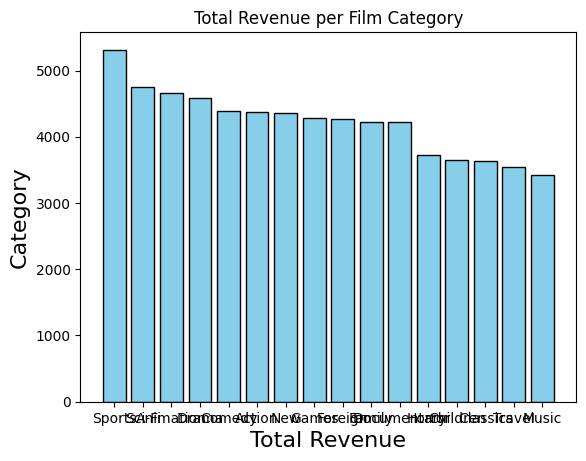

In [21]:
#2b

category_film_mostrevenue = duckdb.sql("""
    SELECT
c.name as category_name,
        SUM(p.amount) as total_revenue
    FROM category c
    JOIN film_category fc ON c.category_id = fc.category_id 
    JOIN film f ON fc.film_id = f.film_id 
    JOIN inventory i ON f.film_id = i.film_id
    JOIN rental r ON i.inventory_id = r.inventory_id 
    JOIN payment p ON r.rental_id = p.rental_id 
    GROUP BY category_name
    ORDER BY total_revenue DESC
                                       
""").df()
category_film_mostrevenue.index = category_film_mostrevenue.index + 1

plt.bar(category_film_mostrevenue['category_name'], category_film_mostrevenue['total_revenue'], color = 'skyblue', edgecolor='black')
plt.title('Total Revenue per Film Category', fontsize = 12)
plt.xlabel('Total Revenue', fontsize = 16)
plt.ylabel('Category', fontsize = 16)